## Homework 3: blackbox optimization

In this task you will optimize a true black box function $F$, whose calculation is comparatively expensive. The good new are, that you have an access to another **trial function** $f$, whose evaluation is much cheaper. It is reminiscent of the situation, when one needs to choose the training hyperparameters of some large model: you can try to study the effect of these hyperparameters on smaller model, and you can make some trial runs.

Your final goal is to find the alrges possible value of the blackbox function as possible while minimizing the number of calculations. You have two types of actions: calculate $f(x)$ or $F(x)$. To be concrete, if you  calculated $f(x_1) \dots f(x_n)$ and $F(X_1)\dots F(X_N)$, then your final score would be
$$
score = \max\limits{1 \leq i \leq N}F(X_i) - CN - cn
$$
with constant $C$ and $c$ equal to $1$ and $0.01$ respectively.

The only thing you know about these functions is that both are defined over $\left[-1, 1 \right]^2$, and they are *somewhat smooth*.

### How to calculate functions

Both large and small functions are availabe at http://optimize-me.ddns.net:8080/, and to access its values you need to send a POST request with three fields:`type`, `secret_key` and `x`. For example:

```bash
curl -X POST http://optimize-me.ddns.net:8080/ -d "secret_key=$MY_KEY" -d "x=-0.5 -0.5" -d "type=small"
```

1. The `secret_key` is your identifier. To obtain it, generate an arbitrary string of utf8 characters and PM it to me. You would be able to make submissions only after I add your identifier to the list of allowed users.
2. The `x` field must contain two float numbers separated by single whitespace -- the coordinates of poit to query.
3. The `type` can be either `small` or `large`: the type of a function to evaluate.
4. The response contains either a single float (falue of the function at x) or an error string.

### How to get teh score
```bash
curl -X POST http://optimize-me.ddns.net:8080/ -d "secret_key=$MY_KEY" -d "type=score"
```

#### The rules
1. Have fun and don't cheat.
2. Allowed modules: `numpy`, `pandas`, `scipy`, `requests` and their dependencies.
2. The maximum score is 10. You get 4, 6, 8, 10 stars for achieving the final score of 50, 70, 90 and 110 resoectively.
3. If you achieved the highest score among all participants, you get **two additional stars**. If you are in top-5, you get **one additional star**.
4. **You are limited to one request per second.** More frequent responses would be responded with an error string, but **counted towards your number of trials**.
5. There are plenty of different black-box optimization schemes. If you do something beyond applying scipy.optimize and what we did in class, I will invite you to give a 5-10 minutes talk onone of the following practical lessons to earn one more star.
6. The server **WILL** die occasionally (especially when the deadline is near), your code should not fail in this case. If it doesn't respond to you for more than 2 hours, then PM me.
7. If you found a bug or your requests do not work for some reason -- PM me.
8. To sumbit your work, send the code to me as a **python script which reproduces your results**
9. Deadline: 20.03.2025.


In [ ]:
import numpy as np
import pandas as pd
import scipy
import requests
from time import sleep

Запросы на маленькую для интерполирования тренировочной функции

In [ ]:
f_small_values = []

for x1 in np.linspace(-1, 1, 10):
    for x2 in np.linspace(-1, 1, 10):
            sleep(1.1)
            #x = requests.post('http://optimize-me.ddns.net:8080/', data={'secret_key': 'ozxm*=as;-', 'x': f'{x1} {x2}', 'type': 'small'})

            f_small_values.append((x1, x2, x.text))

In [ ]:
f_small_df = pd.DataFrame(f_small_values, columns=['x1', 'x2', 'y'])
f_small_df

In [ ]:
f_small_df.to_csv('/kaggle/working/small_f.csv')

Не теряем точки

In [ ]:
f_small_df = pd.read_csv('/kaggle/input/small-f/small_f.csv', index_col=0)

In [ ]:
max(f_small_df['y'])

207.732383

Интерполируем

In [ ]:
grid_x, grid_y = np.mgrid[-1:1:500j, -1:1:500j]
from scipy.interpolate import CloughTocher2DInterpolator
inter_func = CloughTocher2DInterpolator(f_small_df[['x1', 'x2']], f_small_df['y'])

In [ ]:
interpol = pd.DataFrame(np.hstack([grid_x.reshape(250000, 1), grid_y.reshape(250000, 1), inter_func((grid_x, grid_y)).reshape(250000, 1)]), columns=['x1', 'x2', 'y'])

Интерполированная функция

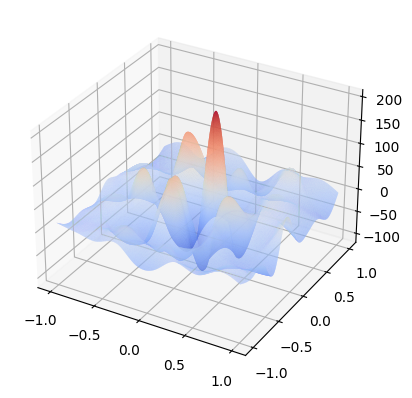

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(interpol['x1'], interpol['x2'], interpol['y'], cmap=cm.coolwarm)
plt.show()

In [ ]:
np.max(inter_func((grid_x, grid_y)))

208.09726041955324

Пишем ядро

In [ ]:
def kernel(a, b, l):

    #sqdist = np.sum((a/l)**2,axis=1).reshape(-1,1) + np.sum((b/l)**2,axis=1) - 2 * (a/l) @ (b/l).T
    # return sigma**2 * np.exp(-0.5*(1/l**2) * sqdist)
    d = scipy.spatial.distance.cdist(a/l, b/l, metric='euclidean')
    return (1 + 5**0.5 * d + (5/3) * d**2) * np.exp(-5**0.5 * d)

In [ ]:
grid_x, grid_y = np.mgrid[-1:1:50j, -1:1:50j]
X_train = np.array(f_small_df[['x1', 'x2']])
Y_train = np.array(f_small_df['y'])
X_s = np.hstack([grid_x.reshape(2500, 1), grid_y.reshape(2500, 1)])

In [ ]:
l_param = 1

Пишем предикт ядра

In [ ]:
def posterior(X_s, X_train, Y_train, l=1, sigma_y=0.01, optimizer=False):

    if optimizer:
        global l_param
        res = scipy.optimize.minimize(nll_fn(X_train, Y_train, noise_2D), [1, 1],
               bounds=((12e-2, None)),
               method='L-BFGS-B')
        l_param = res.x[0]
        l = l_param

    else:
        K = kernel(X_train, X_train, l) + sigma_y**2 * np.eye(len(X_train))
        K_s = kernel(X_train, X_s, l)
        K_ss = kernel(X_s, X_s, l) + 0.01 * np.eye(len(X_s))
        K_inv = np.linalg.inv(K)

        mu_s = K_s.T.dot(K_inv).dot(Y_train)

        cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

        return mu_s, cov_s

Оптимизация гиперпараметров

In [ ]:
def nll_fn(X_train, Y_train, noise):

    Y_train = Y_train.ravel()

    def nll_stable(l):

        K = kernel(X_train, X_train, l=l) + \
            noise**2 * np.eye(len(X_train))
        L = scipy.linalg.cholesky(K)

        S1 = scipy.linalg.solve_triangular(L, Y_train, lower=True)
        S2 = scipy.linalg.solve_triangular(L.T, S1, lower=False)

        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.dot(S2) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    return nll_stable

In [ ]:
def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=1, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

Плотим оптимизацию с ограничением нижней границы параметров подобранным эмпирически

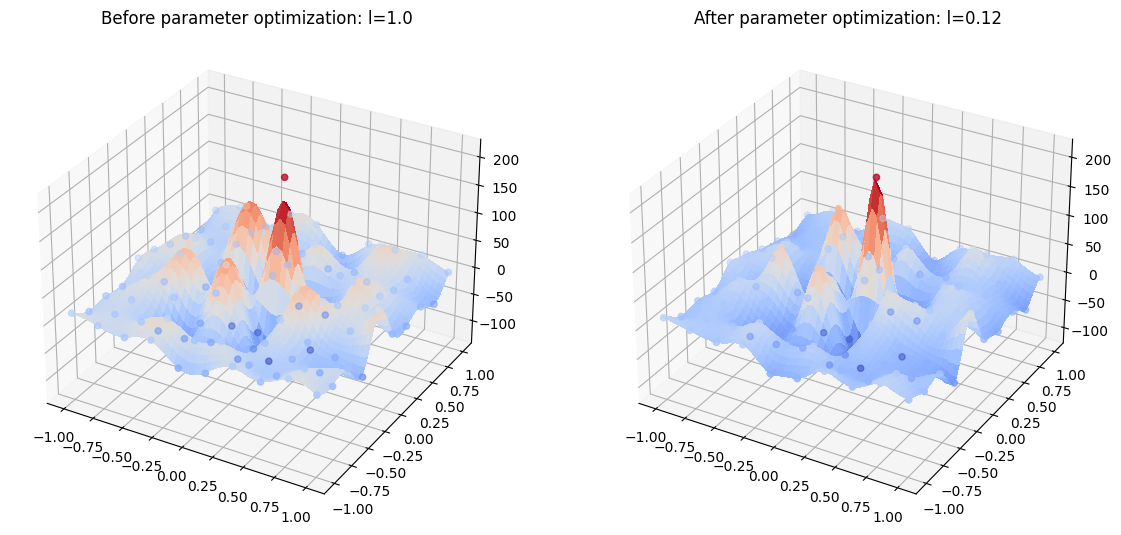

In [ ]:
noise_2D = 0.01

gx, gy = np.mgrid[-1:1:50j, -1:1:50j]

plt.figure(figsize=(14,7))

mu_s, _ = posterior(X_s, X_train, Y_train, sigma_y=noise_2D, optimizer=False)
plot_gp_2D(gx, gy, mu_s, X_train, Y_train,
           f'Before parameter optimization: l={1.00}', 1)

result = scipy.optimize.minimize(nll_fn(X_train, Y_train, noise_2D), 1,
               bounds=[[12e-2, None]],
               method='L-BFGS-B')

mu_s, _ = posterior(X_s, X_train, Y_train, result.x, sigma_y=noise_2D, optimizer=False)
plot_gp_2D(gx, gy, mu_s, X_train, Y_train,
           f'After parameter optimization: l={result.x[0]:.2f}', 2)

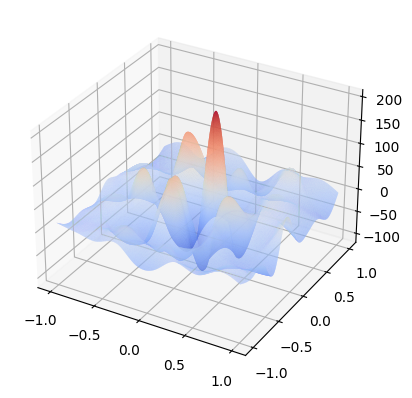

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(interpol['x1'], interpol['x2'], interpol['y'], cmap=cm.coolwarm)
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

Насколько приближение похоже на интерполированную функцию

In [ ]:
mean_absolute_error(mu_s, inter_func(gx,gy).reshape(1, -1).ravel())

5.697265332262524

In [ ]:
r2_score(mu_s, inter_func(gx,gy).reshape(1, -1).ravel())

0.9085352343258346

Аквизишон фанкшон (бета подобрана эмпирически)

In [ ]:
def expected_improvement(X, X_sample, Y_sample, beta=3, **kwargs):
    mu, cov = posterior(X, X_sample, Y_sample, l=l_param, sigma_y=0.01, optimizer=False)
    sigma = np.sqrt(np.diag(cov))

    return mu + beta * sigma

Поиск точки с оптимальными координатами для запроса

In [ ]:
def propose_location(acquisition, X_sample, Y_sample, bounds, n_restarts=400):

    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):

        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample).flatten()

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = scipy.optimize.minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:

            min_val = res.fun
            min_x = res.x
    print(min_val)
    print(min_x)
    return min_x.reshape(-1, 1)

Функция для запроса значений на большой функции

In [ ]:
def macro_request(X:np.array) -> np.array:
    Y = []
    for i in X:
        sleep(1.1)
        req = requests.post('http://optimize-me.ddns.net:8080/', data={'secret_key': 'ozxm*=as;-', 'x': f'{i[0]} {i[1]}', 'type': 'large'})
        Y.append(float(req.text))

    return np.array(Y)

Байесовская оптимизация

In [ ]:
np.random.seed(4)
rand = np.random.randint(0, 250000, size=5)
X_init = np.array(interpol[['x1', 'x2']].iloc[rand])
Y_init = macro_request(X_init)

X_sample = X_init
Y_sample = Y_init.reshape(-1,1)

bounds = np.array([[-1.0, 1.0]])

n_iter = 30

l_param = 1.5

for i in range(n_iter):

    #_ = posterior(X_sample, X_sample, Y_sample, l_param, sigma_f_param, optimizer=True)

    X_next = propose_location(expected_improvement, X_sample, Y_sample, bounds).ravel()

    Y_next = macro_request([X_next])

    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

-65.6955159411076
[-0.15800903 -1.        ]
-32.79654915319644
[ 0.06482725 -0.26034538]
-137.85042447895304
[-0.93807735 -0.07207499]
-131.0434797795406
[-0.88600723 -0.07100382]
-323.92565665152483
[-1. -1.]
-257.84416966864325
[-1.          0.47577726]
-223.6614285789668
[-1.         -0.21861796]
-254.50342509186987
[-1.          0.11360751]
-130.31548560817535
[-1.          0.02090379]
-150.94206062818847
[-1.         0.0088949]
-156.46999940170855
[-1.          0.00565944]
-158.83133703407762
[-1.          0.00424055]
-160.10792116700452
[-1.          0.00345391]
-160.89735852644722
[-1.          0.00295652]
-161.42957553335003
[-1.          0.00261421]
-161.81058671766823
[-1.         0.0023654]
-162.09568569095606
[-1.          0.00217645]
-162.31636556919432
[-1.          0.00202778]
-162.4918090186184
[-1.          0.00190863]
-162.63435848293895
[-1.          0.00181064]
-162.75227686790745
[-1.          0.00172873]
-162.8513023524998
[-1.          0.00165911]
-162.9355357278

In [ ]:
max(Y_sample)

array([164.895847])

In [ ]:
Y_sample

array([[ 7.42362100e+00],
       [ 5.60116800e+00],
       [-6.58258400e+00],
       [ 1.38070000e-01],
       [ 3.17306060e+01],
       [-2.26994580e+01],
       [ 3.68522900e+00],
       [ 1.30512051e+02],
       [ 3.17899520e+01],
       [ 1.10322100e+00],
       [-3.65935800e+00],
       [ 2.65892500e+00],
       [ 1.08380263e+02],
       [ 1.64895847e+02],
       [ 1.64890933e+02],
       [ 1.64492113e+02],
       [ 1.64262813e+02],
       [ 1.64121315e+02],
       [ 1.64026546e+02],
       [ 1.63958933e+02],
       [ 1.63908566e+02],
       [ 1.63869628e+02],
       [ 1.63838570e+02],
       [ 1.63813414e+02],
       [ 1.63792550e+02],
       [ 1.63774985e+02],
       [ 1.63759970e+02],
       [ 1.63747086e+02],
       [ 1.63735760e+02],
       [ 1.63725943e+02],
       [ 1.63717182e+02],
       [ 1.63709404e+02],
       [ 1.63702502e+02],
       [ 1.63696128e+02],
       [ 1.63690477e+02]])

Как можно увидеть, оптимизация сошлась со значением 160+